# Predicting the take time for shipping food delivery

In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns

from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

from src.feature_engineer import vincenty_distance, bearing_degree
from src.feature_selection import (
    create_plot_correlation,
    rfe_feature_selection,
    feature_importance,
)
from src.metrics import metrics_values

/tmp/ipykernel_122513/3599971869.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-09 16:11:23.140899: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 16:11:23.347859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 16:11:23.347938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugi

In [2]:
path = os.path.join("data", "food_delivery.csv")
df = pd.read_csv(path, sep=";")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


In [3]:
df["vincenty_distance"] = df.apply(
    lambda row: vincenty_distance(
        row["Restaurant_latitude"],
        row["Restaurant_longitude"],
        row["Delivery_location_latitude"],
        row["Delivery_location_longitude"],
    ),
    axis=1,
)

In [4]:
df["bearing_distance"] = df.apply(
    lambda row: bearing_degree(
        row["Restaurant_latitude"],
        row["Restaurant_longitude"],
        row["Delivery_location_latitude"],
        row["Delivery_location_longitude"],
    ),
    axis=1,
)

In [5]:
# Type_of_order

dic_name = {
    "Snack ": 1,
    "Drinks ": 2,
    "Buffet ": 3,
    "Meal ": 4,
    # Type_of_vehicle
    "motorcycle ": 1,
    "scooter ": 2,
    "electric_scooter ": 3,
    "bicycle ": 4,
}


df = df.replace(dic_name)

/tmp/ipykernel_122513/391141819.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(dic_name)


Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(
        columns=[
            "Time_taken(min)",
            "ID",
            "Delivery_person_ID",
            "Restaurant_latitude",
            "Restaurant_longitude",
            "Delivery_location_latitude",
            "Delivery_location_longitude",
        ]
    ),
    df["Time_taken(min)"],
    test_size=0.25,
    random_state=42,
)

Feature Selection

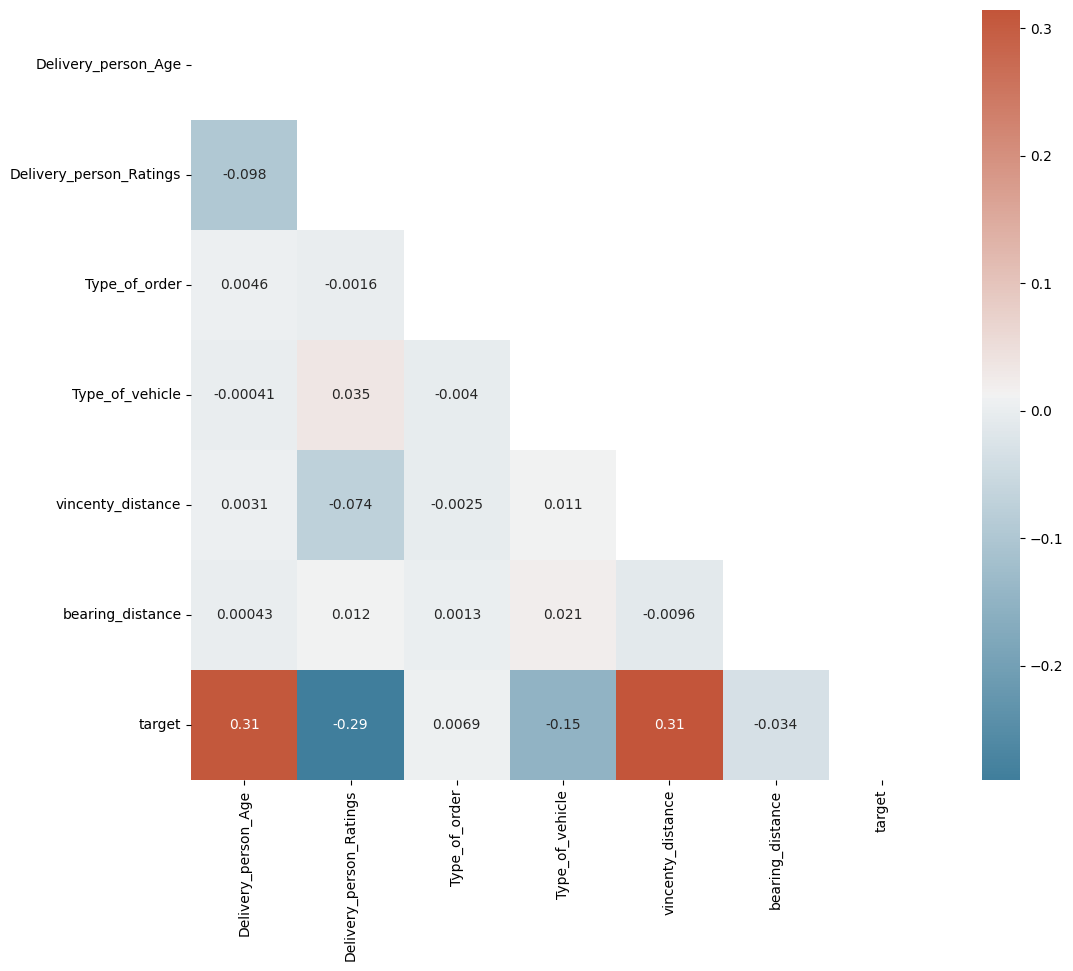

In [8]:
create_plot_correlation(X_train, y_train, "spearman")

Mean Squared Error: 70.0797121287864


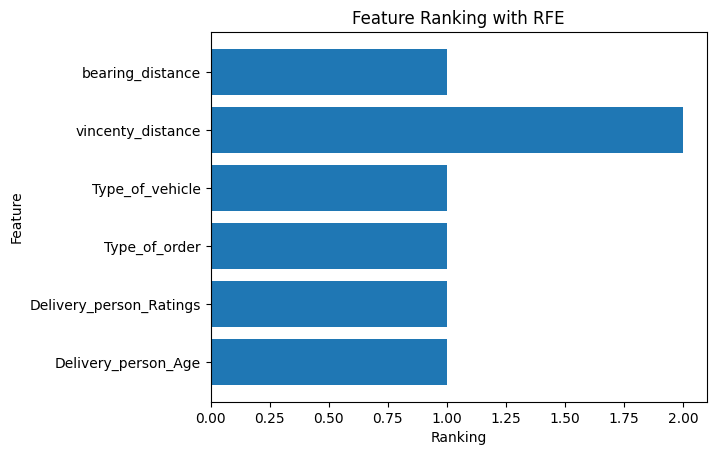

In [9]:
rfe_columns = rfe_feature_selection(X_train, y_train, "LinearRegression", 5)

Feature: Delivery_person_Age, Score:0.16942
Feature: Delivery_person_Ratings, Score:0.26569
Feature: Type_of_order, Score:0.0604
Feature: Type_of_vehicle, Score:0.03785
Feature: vincenty_distance, Score:0.28885
Feature: bearing_distance, Score:0.17779


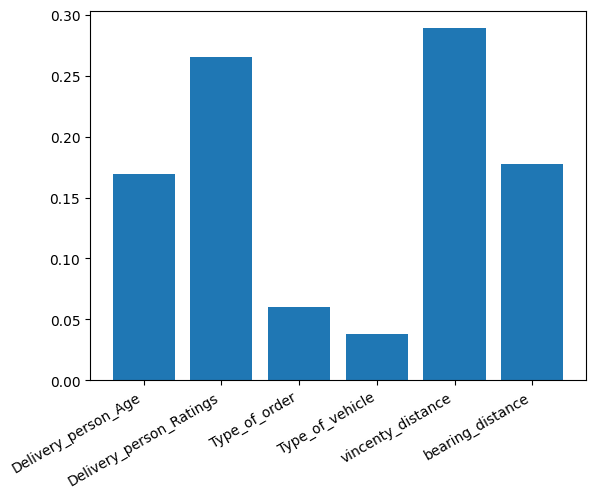

In [10]:
feature_importance(X_train, y_train, "RandomForestRegressor")

Feature: Delivery_person_Age, Score:0.14691999554634094
Feature: Delivery_person_Ratings, Score:0.4296799898147583
Feature: Type_of_order, Score:0.03237999975681305
Feature: Type_of_vehicle, Score:0.14384999871253967
Feature: vincenty_distance, Score:0.21186000108718872
Feature: bearing_distance, Score:0.03531000018119812


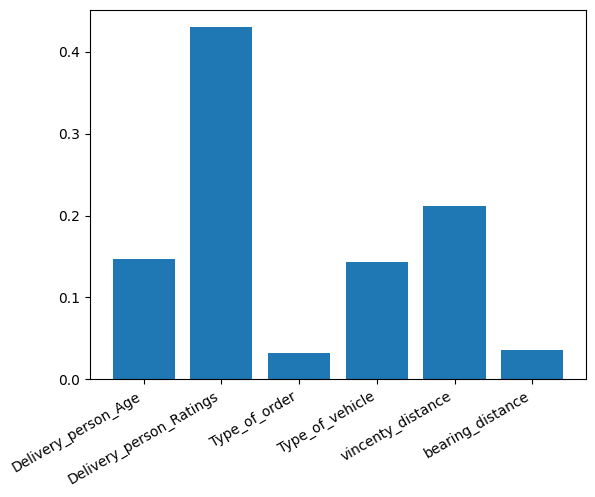

In [11]:
feature_importance(X_train, y_train, "XGboost")

Training Model

In [12]:
feature_used = [
    "Delivery_person_Age",
    "Delivery_person_Ratings",
    "Type_of_vehicle",
    "vincenty_distance",
    "bearing_distance",
]

In [13]:
model_gbost = XGBRegressor()
model_gbost.fit(X_train[feature_used], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
model = Sequential()
model.add(
    LSTM(
        128,
        return_sequences=True,
        input_shape=(np.array(X_train[feature_used]).shape[1], 1),
    )
)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(np.array(X_train[feature_used]), np.array(y_train), batch_size=1, epochs=6)

Epoch 1/6
34194/34194 [==============================] - 170s 5ms/step - loss: 71.0403
Epoch 2/6
34194/34194 [==============================] - 150s 4ms/step - loss: 61.6677
Epoch 3/6
34194/34194 [==============================] - 158s 5ms/step - loss: 60.1413
Epoch 4/6
34194/34194 [==============================] - 163s 5ms/step - loss: 59.0382
Epoch 5/6
34194/34194 [==============================] - 149s 4ms/step - loss: 58.2057
Epoch 6/6
34194/34194 [==============================] - 126s 4ms/step - loss: 57.4882


Valuating models

In [16]:
predict_xgbost = model_gbost.predict(X_test[feature_used])

In [17]:
predict_lstm = model.predict(np.array(X_test[feature_used]))

357/357 [==============================] - 1s 2ms/step


In [18]:
table = pd.DataFrame({"y_test": y_test, "predict_xgbost": predict_xgbost}).reset_index(
    drop=True
)

table["predict_lstm"] = predict_lstm
table

,y_test,predict_xgbost,predict_lstm
0,44,33.480042,29.085855
1,41,30.685728,31.998711
2,39,34.380413,37.453320
3,38,34.037251,32.924736
4,38,26.145216,26.050682
...,...,...,...
11394,29,19.526772,20.630505
11395,42,36.891129,39.411724
11396,24,19.299515,22.918785
11397,41,38.518028,37.360348


In [19]:
result_xgbost = metrics_values(table["y_test"], table["predict_xgbost"])
result_lstm = metrics_values(table["y_test"], table["predict_lstm"])

Mean Absolute Error (MAE): 5.7589960542517025
Mean Squared Error (MSE): 53.837101212812364
Root Mean Squared Error (RMSE): 7.337376998138528
Mean Squared Logarithmic Error (MSLE): 0.08161522424288059
Median Absolute Error (MedAE): 4.736442565917969
R-squared (R2): 0.3859167035357687
Explained Variance Score: 0.385969263661335
Mean Absolute Error (MAE): 5.859785480869058
Mean Squared Error (MSE): 55.072328961351836
Root Mean Squared Error (RMSE): 7.421073302518432
Mean Squared Logarithmic Error (MSLE): 0.08369776537757108
Median Absolute Error (MedAE): 4.901863098144531
R-squared (R2): 0.37182729844858153
Explained Variance Score: 0.3732866760126471


/home/samuel/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/samuel/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: xlabel='y_test', ylabel='predict_xgbost'>

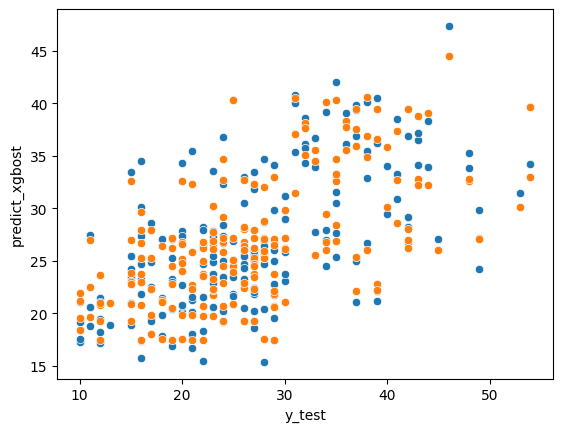

In [36]:
sns.scatterplot(data=table.tail(200), x="y_test", y="predict_xgbost")
sns.scatterplot(data=table.tail(200), x="y_test", y="predict_lstm")

In [26]:
table.reset_index()

,index,y_test,predict_xgbost,predict_lstm
0,0,44,33.480042,29.085855
1,1,41,30.685728,31.998711
2,2,39,34.380413,37.453320
3,3,38,34.037251,32.924736
4,4,38,26.145216,26.050682
...,...,...,...,...
11394,11394,29,19.526772,20.630505
11395,11395,42,36.891129,39.411724
11396,11396,24,19.299515,22.918785
11397,11397,41,38.518028,37.360348
